## Pokemon Data
I recently came across a "complete" pokemon data set, and I wanted to investigate it, so here I am. I say "complete" because it only contains pokemon up until Sun and Moon. But hey, I'm not one to be picky about my datasets. DISCLAIMER: I am in no shape or form an expert of pokemon, I just really like pokemon and have been playing it since I was a little kid.

In [329]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
# Higher resolution figures

from warnings import filterwarnings

import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Dataset at a First Glance
This is a very descriptive dataset, and that's not surprising; the result of a pokemon battle can sometimes come down to the most minute statistical detail. That being said, I am not an expert in pokemon battles and statistics...I merely just attack on every turn in a brute force manner.

In [330]:
df = pd.read_csv('data/pokemon.csv')
pokemons = df.copy()
pokemons.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


### Most Common (Primary) Types
This is interesting to me because I always thought normal would be the most common. I also did not expect flying type to be the least common over fairy since there are so many winged creatures in the pokemon world.

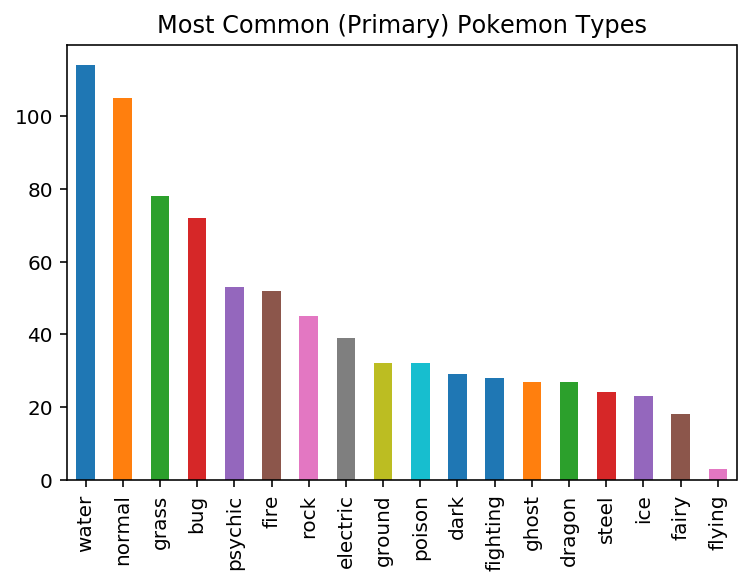

In [331]:
pokemons['type1'].value_counts().plot(kind = 'bar', title = 'Most Common (Primary) Pokemon Types')

### Most Common (Secondary) Types
This makes a little more sense now that we see a distribution of sorts for secondary pokemon types. Now that I think about it, I rarely see pokemon that are primarily or purely flying type. Most "flying" pokemon are like charizard, they don't have flying as their primary type.

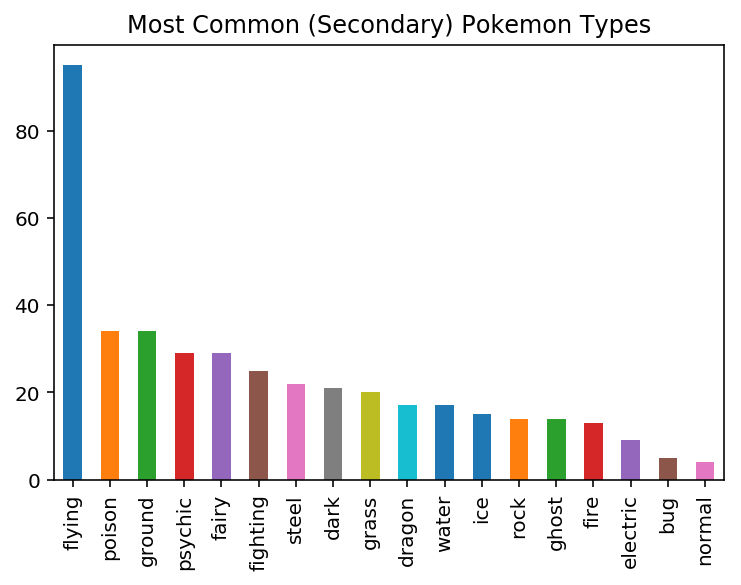

In [332]:
pokemons['type2'].value_counts().plot(kind = 'bar', title = 'Most Common (Secondary) Pokemon Types')

### Most Common Type Combos
I feel like this paints the most complete picture of pokemon types and their frequency. Although I still am quite curious as to why water type pokemon are so common.

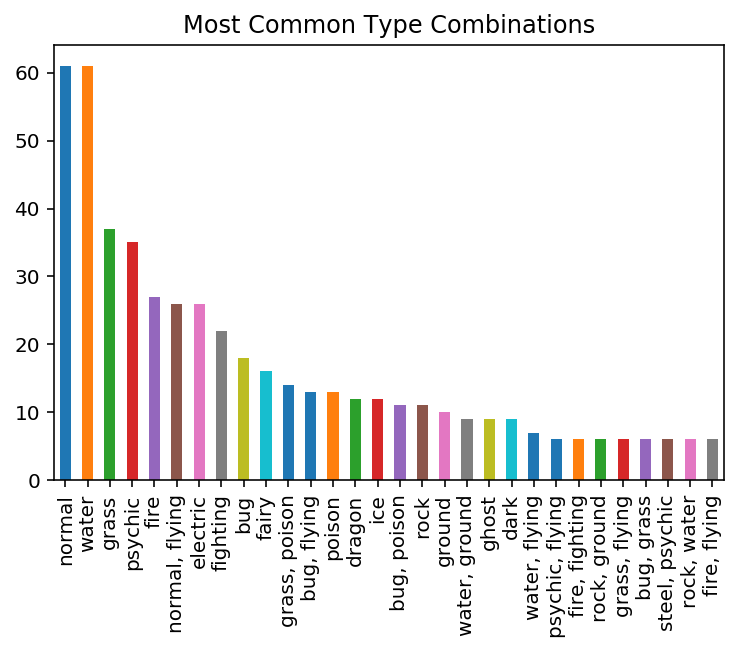

In [333]:
(
    (pokemons['type1'] + ", " + pokemons['type2'])
    .fillna(pokemons['type1'])
    .value_counts()
    .head(30)
    .plot(kind = 'bar', title = 'Most Common Type Combinations')
)

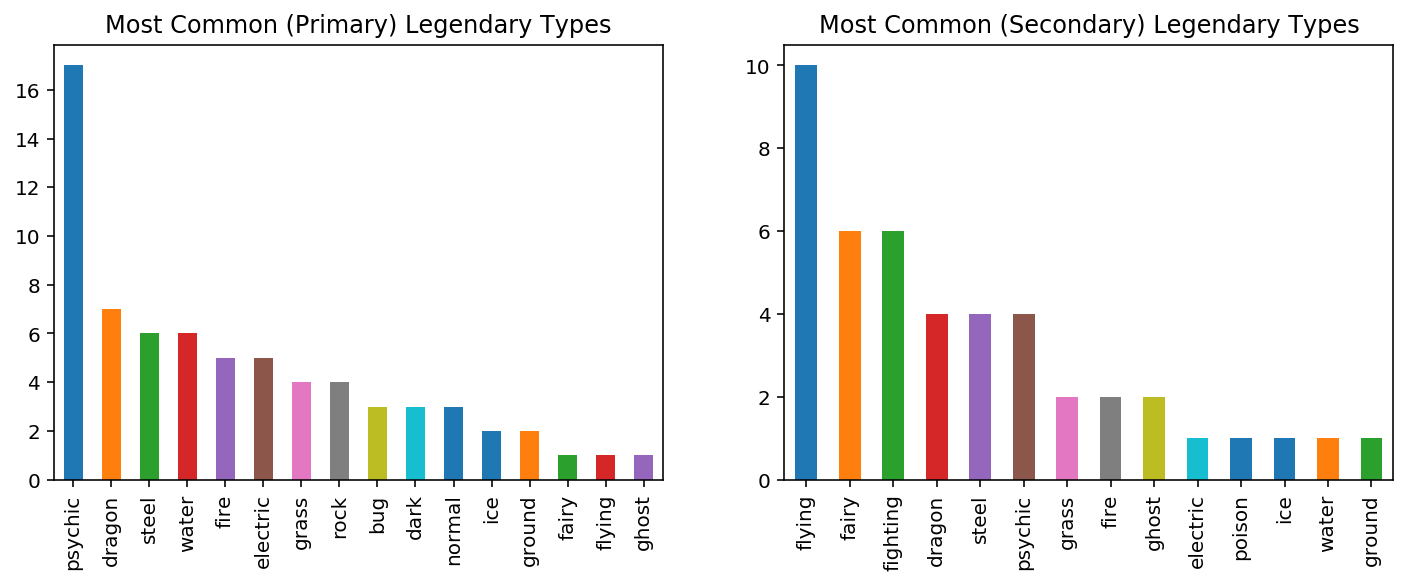

In [334]:
legends = pokemons[pokemons['is_legendary'] == 1]
fig, axes = plt.subplots(1, 2, figsize=(12,4))
legends['type1'].value_counts().plot(kind = 'bar', ax=axes[0], title = 'Most Common (Primary) Legendary Types')
legends['type2'].value_counts().plot(kind = 'bar', ax=axes[1], title = 'Most Common (Secondary) Legendary Types')

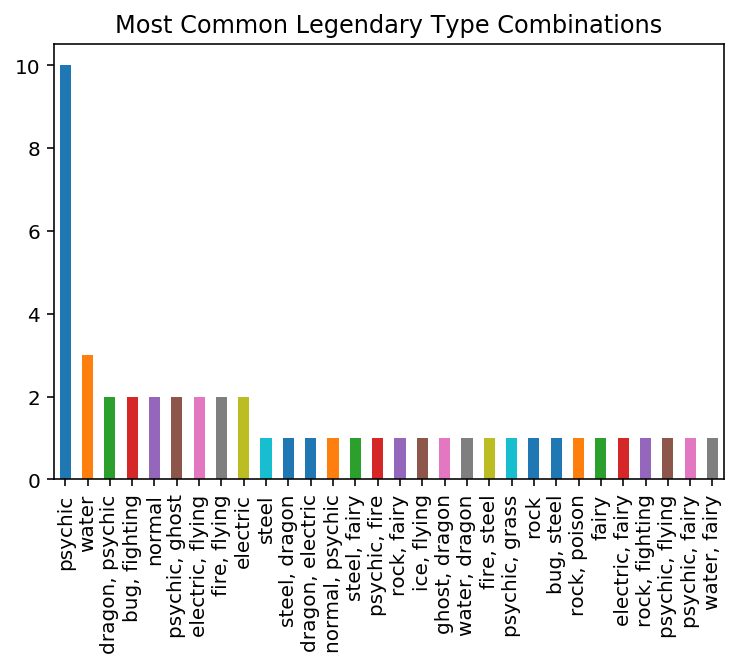

In [335]:
(
    (legends['type1'] + ", " + legends['type2'])
    .fillna(pokemons['type1'])
    .value_counts()
    .head(30)
    .plot(kind = 'bar', title = 'Most Common Legendary Type Combinations')
)

In [336]:
(
    (legends['type1'] + ", " + legends['type2'])
    .fillna(pokemons['type1'])
    .value_counts(normalize = True)
    .head(30)
)

psychic             0.142857
water               0.042857
dragon, psychic     0.028571
bug, fighting       0.028571
normal              0.028571
psychic, ghost      0.028571
electric, flying    0.028571
fire, flying        0.028571
electric            0.028571
steel               0.014286
steel, dragon       0.014286
dragon, electric    0.014286
normal, psychic     0.014286
steel, fairy        0.014286
psychic, fire       0.014286
rock, fairy         0.014286
ice, flying         0.014286
ghost, dragon       0.014286
water, dragon       0.014286
fire, steel         0.014286
psychic, grass      0.014286
rock                0.014286
bug, steel          0.014286
rock, poison        0.014286
fairy               0.014286
electric, fairy     0.014286
rock, fighting      0.014286
psychic, flying     0.014286
psychic, fairy      0.014286
water, fairy        0.014286
dtype: float64

In [337]:
type_combos = (pokemons['type1'] + ", " + pokemons['type2']).fillna(pokemons['type1'])
temp = pokemons.assign(**{'type': type_combos})
temp['type'].head()

0    grass, poison
1    grass, poison
2    grass, poison
3             fire
4             fire
Name: type, dtype: object

### Data Cleaning
Lets start off with some cleaning. At first glance, I can see a couple columns like japanese name and pokedex number that doesn't really provide meaningful information, so I'll go ahead and drop those.

In [338]:
pokemons.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

In [339]:
temp = (
    pokemons.drop('japanese_name', axis = 1)
    .drop('pokedex_number', axis = 1)
)
print(pokemons.shape)
print(temp.shape)

(801, 41)
(801, 39)


In [340]:
pokemons = temp

In [341]:
pokemons.isnull().mean()

abilities            0.000000
against_bug          0.000000
against_dark         0.000000
against_dragon       0.000000
against_electric     0.000000
against_fairy        0.000000
against_fight        0.000000
against_fire         0.000000
against_flying       0.000000
against_ghost        0.000000
against_grass        0.000000
against_ground       0.000000
against_ice          0.000000
against_normal       0.000000
against_poison       0.000000
against_psychic      0.000000
against_rock         0.000000
against_steel        0.000000
against_water        0.000000
attack               0.000000
base_egg_steps       0.000000
base_happiness       0.000000
base_total           0.000000
capture_rate         0.000000
classfication        0.000000
defense              0.000000
experience_growth    0.000000
height_m             0.024969
hp                   0.000000
name                 0.000000
percentage_male      0.122347
sp_attack            0.000000
sp_defense           0.000000
speed     

In [342]:
pokemons[~pokemons['percentage_male'].isnull()]['is_legendary'].sum() / legends.shape[0]

0.1

In [343]:
pokemons[(pokemons['is_legendary'] == 1) & (~pokemons['percentage_male'].isnull())].name

379       Latias
380       Latios
484      Heatran
487    Cresselia
640     Tornadus
641    Thundurus
644     Landorus
Name: name, dtype: object

In [344]:
temp = pokemons.copy()
temp['type2'] = temp['type2'].fillna('None')
temp.isnull().mean()

abilities            0.000000
against_bug          0.000000
against_dark         0.000000
against_dragon       0.000000
against_electric     0.000000
against_fairy        0.000000
against_fight        0.000000
against_fire         0.000000
against_flying       0.000000
against_ghost        0.000000
against_grass        0.000000
against_ground       0.000000
against_ice          0.000000
against_normal       0.000000
against_poison       0.000000
against_psychic      0.000000
against_rock         0.000000
against_steel        0.000000
against_water        0.000000
attack               0.000000
base_egg_steps       0.000000
base_happiness       0.000000
base_total           0.000000
capture_rate         0.000000
classfication        0.000000
defense              0.000000
experience_growth    0.000000
height_m             0.024969
hp                   0.000000
name                 0.000000
percentage_male      0.122347
sp_attack            0.000000
sp_defense           0.000000
speed     

In [345]:
temp.height_m.describe()

count    781.000000
mean       1.163892
std        1.080326
min        0.100000
25%        0.600000
50%        1.000000
75%        1.500000
max       14.500000
Name: height_m, dtype: float64

In [346]:
temp['height_m'] = temp.height_m.fillna(pokemons.height_m.mean())
temp.height_m.describe()

count    801.000000
mean       1.163892
std        1.066737
min        0.100000
25%        0.600000
50%        1.000000
75%        1.500000
max       14.500000
Name: height_m, dtype: float64

In [347]:
temp.weight_kg.describe()

count    781.000000
mean      61.378105
std      109.354766
min        0.100000
25%        9.000000
50%       27.300000
75%       64.800000
max      999.900000
Name: weight_kg, dtype: float64

In [348]:
temp['weight_kg'] = temp.weight_kg.fillna(pokemons.weight_kg.mean())
temp.weight_kg.describe()

count    801.000000
mean      61.378105
std      107.979179
min        0.100000
25%        9.300000
50%       28.500000
75%       61.500000
max      999.900000
Name: weight_kg, dtype: float64

In [349]:
pokemons = temp
pokemons.isnull().mean()

abilities            0.000000
against_bug          0.000000
against_dark         0.000000
against_dragon       0.000000
against_electric     0.000000
against_fairy        0.000000
against_fight        0.000000
against_fire         0.000000
against_flying       0.000000
against_ghost        0.000000
against_grass        0.000000
against_ground       0.000000
against_ice          0.000000
against_normal       0.000000
against_poison       0.000000
against_psychic      0.000000
against_rock         0.000000
against_steel        0.000000
against_water        0.000000
attack               0.000000
base_egg_steps       0.000000
base_happiness       0.000000
base_total           0.000000
capture_rate         0.000000
classfication        0.000000
defense              0.000000
experience_growth    0.000000
height_m             0.000000
hp                   0.000000
name                 0.000000
percentage_male      0.122347
sp_attack            0.000000
sp_defense           0.000000
speed     

In [350]:
attacks = []
for i in pokemons.columns:
    if re.search('^against', i) != None:
        attacks.append(i)
attacks

['against_bug',
 'against_dark',
 'against_dragon',
 'against_electric',
 'against_fairy',
 'against_fight',
 'against_fire',
 'against_flying',
 'against_ghost',
 'against_grass',
 'against_ground',
 'against_ice',
 'against_normal',
 'against_poison',
 'against_psychic',
 'against_rock',
 'against_steel',
 'against_water']

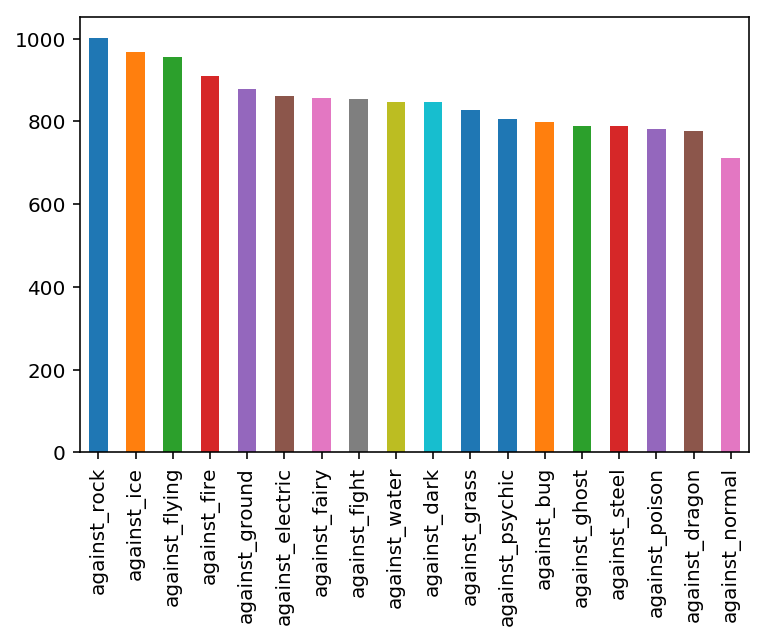

In [351]:
pokemons[attacks].sum().sort_values(ascending = False).plot(kind = 'bar')

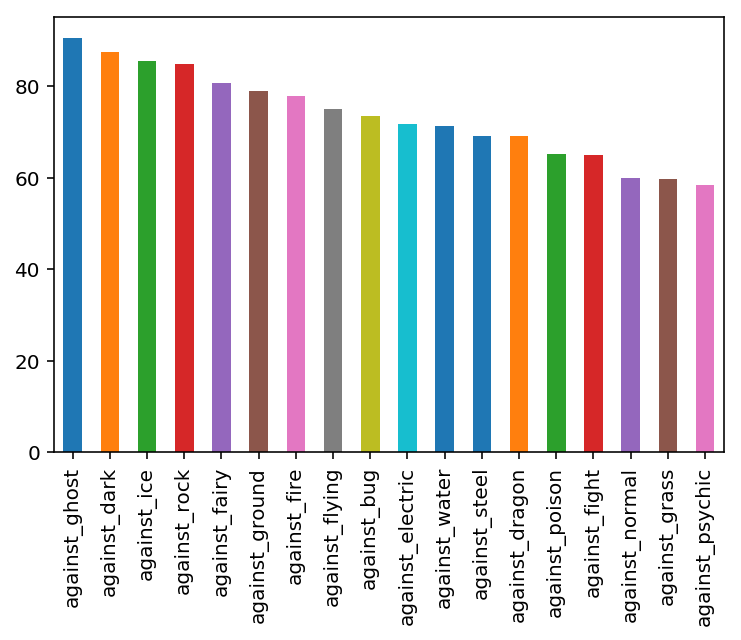

In [352]:
legends[attacks].sum().sort_values(ascending = False).plot(kind = 'bar')

In [353]:
pokemons['has_gender'] = pokemons['percentage_male'].isnull().astype(int)
pokemons['has_gender'].unique()

array([0, 1])

In [631]:
X = pokemons.drop(['is_legendary', 'percentage_male'], axis = 1)
X['capture_rate'] = X['capture_rate'].replace({'30 (Meteorite)255 (Core)': 255})
y = pokemons.is_legendary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
train_names = X_train.name
test_names = X_test.name
X = X.drop('name', axis = 1)
X_train = X_train.drop('name', axis = 1)
X_test = X_test.drop('name', axis = 1)
cats = ['abilities', 'classfication', 'type1', 'type2']
quants = [x for x in X.columns if x not in cats]
preproc_base = ColumnTransformer(transformers = [
    ('ohe', OneHotEncoder(handle_unknown = 'ignore', sparse = False), cats),
    ('do-nothing', FunctionTransformer(lambda x: x, validate = True), quants)
])
pl_base = Pipeline(steps = [
    ('preproc', preproc_base),
    ('dtr', DecisionTreeClassifier())
])

In [632]:
pl_base.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preproc', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, s...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [633]:
pl_base.score(X_test, y_test)

1.0

In [634]:
from sklearn import metrics
preds = pl_base.predict(X_test)
# Recall: proportion of legendaries that were correctly identified
# TP/P
metrics.recall_score(y_test, preds)

1.0

In [635]:
# Counts of TN / FP / FN / TP
metrics.confusion_matrix(y_test, preds)

array([[214,   0],
       [  0,  27]])

In [636]:
# Specificity: proportion of non-legendary tumors correctly identified
# TN/N
metrics.recall_score(y_test, preds, pos_label=0)

1.0

In [637]:
# Precision: proportion of predicted legendary pokemon that were actually legendary
metrics.precision_score(y_test, preds)

1.0

In [638]:
# FDR: proportion of predicted legendary pokemon that were actually non-legendary
1 - metrics.precision_score(y_test, preds)

0.0

In [639]:
train_preds = pl_base.predict(X_train)
metrics.recall_score(y_train, train_preds)

1.0

In [640]:
predicted = (
    X_test.assign(predicted = preds)
    .assign(name = test_names)
    .assign(is_legendary = y_test)
)
predicted[predicted['predicted'] != predicted['is_legendary']]['name']

Series([], Name: name, dtype: object)

In [641]:
parameters = {
    'max_depth': [2,3,4,5,7,10,13,15,18,None], 
    'min_samples_split':[2,3,5,7,10,15,20],
    'min_samples_leaf':[2,3,5,7,10,15,20]
}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5)
clf.fit(preproc_base.transform(X_train), y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None], 'min_samples_split': [2, 3, 5, 7, 10, 15, 20], 'min_samples_leaf': [2, 3, 5, 7, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [642]:
clf.best_params_

{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}

In [643]:
clf.best_score_

0.9946428571428572

In [644]:
mdl = DecisionTreeClassifier()
pl_mdl = Pipeline(steps = [
    ('preproc', preproc_base),
    ('dtr', mdl)
])
pl_mdl.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preproc', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, s...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [645]:
print("Accuracy: ")
print(pl_mdl.score(X_test, y_test))
preds_mdl = pl_mdl.predict(X_test)
print("Recall: ")
print(metrics.precision_score(y_test, preds_mdl))

Accuracy: 
1.0
Recall: 
1.0


In [646]:
print("Confusion Matrix: ")
print(metrics.confusion_matrix(y_test, preds_mdl))

Confusion Matrix: 
[[214   0]
 [  0  27]]
